In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib import rc
import os, sys

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

In [3]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import StrainandNoise as SnN

LISA_Other_filedirectory = load_directory + 'LISA_Other/StrainFiles/'
LISA_Neil_filedirectory = load_directory + 'LISA_Neil/StrainFiles/'
LISA_ESA_filedirectory = load_directory + 'LISA_ESA/StrainFiles/'
ET_filedirectory = load_directory + 'EinsteinTelescope/StrainFiles/'
aLIGO_filedirectory = load_directory + 'aLIGO/StrainFiles/'
NANOGrav_filedirectory = load_directory + 'NANOGrav/StrainFiles/' 
EOBdiff_filedirectory = top_directory + '/LoadFiles/DiffStrain/EOBdiff/'

In [5]:
axissize = 14
labelsize = 16
legendsize = 12
figsize = (10,8)
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)
linesize = 3

In [6]:
L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')

####################################################################
# Load data files for transfer function and other sensitivity curves

### LISA Transfer Function

In [7]:
fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=L)
LISA_T_obs = 4*u.yr.to('s')*u.s

### aLIGO

In [8]:
#aLIGO
aLIGO_filename = 'aLIGODesign.txt'
aLIGO_filelocation = aLIGO_filedirectory + aLIGO_filename
aLIGO_data = np.loadtxt(aLIGO_filelocation)
aLIGO_f = aLIGO_data[:,0]*u.Hz
aLIGO_S_n_f = aLIGO_data[:,1]

### Einstein Telescope

In [9]:
#Einstein Telescope
ET_T_obs = 5*u.yr
ET_T_obs = ET_T_obs.to('s')
ET_filename = 'ET_B_data.txt'
ET_filelocation = ET_filedirectory + ET_filename
ET_data = np.loadtxt(ET_filelocation)
ET_f = ET_data[:,0]*u.Hz
ET_S_n_f = ET_data[:,1]

### LISA Martin data

In [10]:
#Martin data
LISA_Martin_filename = 'LISA_Allocation_S_h_tot.txt'
LISA_Martin_filelocation = LISA_Other_filedirectory + LISA_Martin_filename
LISA_Martin_data = np.loadtxt(LISA_Martin_filelocation)
LISA_Martin_f = LISA_Martin_data[:,0]*u.Hz
LISA_Martin_S_n_f = LISA_Martin_data[:,1]/u.Hz

### LISA Neil Cornish data

In [11]:
#Neil Cornish data
LISA_Neil_filename = 'LISA_sensitivity.txt'
LISA_Neil_filelocation = LISA_Neil_filedirectory + LISA_Neil_filename
LISA_Neil_data = np.loadtxt(LISA_Neil_filelocation)
LISA_Neil_f = LISA_Neil_data[:,0]*u.Hz
LISA_Neil_S_n_f = LISA_Neil_data[:,1]/u.Hz

### LISA Larson Sensitivity Curve

In [12]:
#Larson Sensitivity Curve
LISA_Larson_filename = 'scg_6981.dat'
LISA_Larson_filelocation = LISA_Other_filedirectory + LISA_Larson_filename
LISA_Larson_data = np.loadtxt(LISA_Larson_filelocation)
LISA_Larson_f = LISA_Larson_data[:,0]*u.Hz
LISA_Larson_S_n_f = LISA_Larson_data[:,1]/u.Hz #May be wrong units

### Numerical Relativity from EOB subtraction

In [13]:
diff0002_filename = 'diff0002.dat'
diff0002_filelocation = EOBdiff_filedirectory + diff0002_filename
diff0002_data = np.loadtxt(diff0002_filelocation)
diff0002_t = diff0002_data[:,0]*u.Hz
diff0002_hp = diff0002_data[:,1]*u.Hz #May be wrong units
diff0002_hc = diff0002_data[:,2]*u.Hz #May be wrong units

/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [

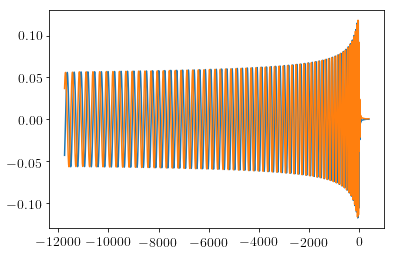

In [14]:
plt.figure()
plt.plot(diff0002_t,diff0002_hc)
plt.plot(diff0002_t,diff0002_hp)
plt.show()

In [20]:
hc_f = np.fft.fft(diff0002_hc)
hp_f = np.fft.fft(diff0002_hp)

In [21]:
win_hc_f,win_hp_f,h_f = SnN.Get_hf_from_hcross_hplus(diff0002_t,diff0002_hc,diff0002_hp)

In [91]:
def FFT_hf_from_hcross_hplus(t,h_cross,h_plus):
    #Converts dimensionless, time domain strain to frequency space
    #Filter/Window beginning
    hann_window = np.hanning(len(t)) #Two sided
    first_half = hann_window[:int(len(t)/2)] # Only need tapering on first half of waveform
    second_half_pt2 = hann_window[int(len(t)/2):]
    second_half = np.ones(len(t)-len(first_half)) #no windowing on second half of waveform
    first_half_pt2 = np.ones(len(t)-len(second_half_pt2))
    window = np.append(first_half_pt2,second_half_pt2) # Only apply window to first half of waveform
    #window = np.append(first_half,second_half) # Only apply window to first half of waveform

    plt.figure()
    plt.plot(window)
    plt.plot(hann_window)
    plt.show()
    
    win_h_cross_t = np.multiply(h_cross,window)
    win_h_plus_t = np.multiply(h_plus,window)
    
    plt.figure()
    plt.plot(win_h_cross_t)
    plt.plot(win_h_plus_t)
    plt.show()
    
    #FFT the two polarizations
    h_cross_f = np.fft.fft(win_h_cross_t)
    h_plus_f = np.fft.fft(win_h_plus_t)
    #Combine them for raw spectral power
    h_f = np.sqrt((np.abs(h_cross_f))**2 + (np.abs(h_plus_f))**2)

    return h_cross_f,h_plus_f,h_f


/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


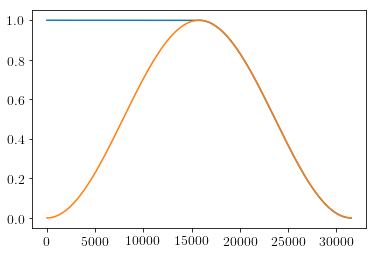

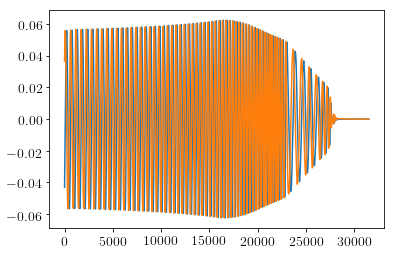

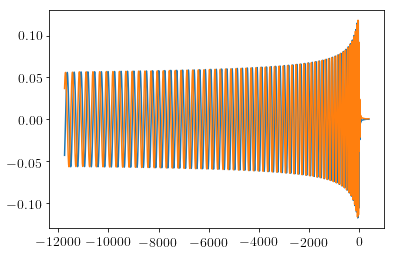

In [92]:
win_hc_f_pt2,win_hp_f_pt2,h_f_pt2 = FFT_hf_from_hcross_hplus(diff0002_t,diff0002_hc,diff0002_hp)
plt.plot(diff0002_t,diff0002_hc)
plt.plot(diff0002_t,diff0002_hp)

In [97]:
print(len(hc_f))
cut=int(len(hc_f)*0.02)
print(cut)

31541
630


/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


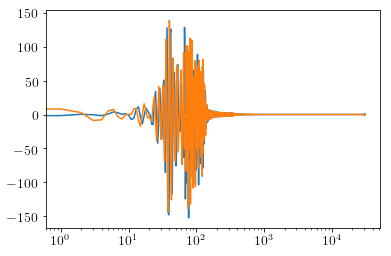

In [98]:
plt.figure()
plt.plot(win_hc_f[:(len(win_hc_f)-cut)])
plt.plot(win_hp_f[:(len(win_hp_f)-cut)])
#plt.plot(h_f[:(len(h_f)-cut)])
plt.xscale('log')
#plt.yscale('log')
plt.show()

/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


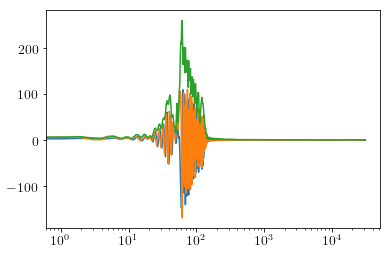

In [103]:
plt.figure()
plt.plot(win_hc_f_pt2[:(len(win_hc_f_pt2)-cut)])
plt.plot(win_hp_f_pt2[:(len(win_hp_f_pt2)-cut)])
plt.plot(h_f_pt2[:(len(h_f_pt2)-cut)])
plt.xscale('log')
#plt.yscale('log')
plt.show()

/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


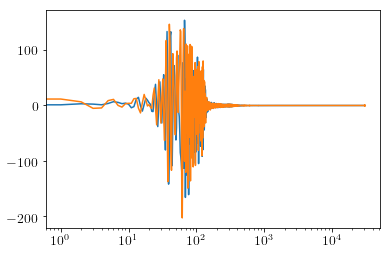

In [100]:
plt.figure()
plt.plot(hc_f[:(len(hc_f)-cut)])
plt.plot(hp_f[:(len(hp_f)-cut)])
plt.xscale('log')
plt.show()

### NANOGrav continuous wave sensitivity

In [12]:
#NANOGrav continuous wave sensitivity
NANOGrav_background = 4e-16 # Unsubtracted GWB amplitude: 0,4e-16
NANOGrav_dp = 0.95 #Detection Probablility: 0.95,0.5
NANOGrav_fap = 0.0001 #False Alarm Probability: 0.05,0.003,0.001,0.0001
NANOGrav_Tobs = 15 #Observation years: 15,20,25

NANOGrav_filename = 'cw_simulation_Ared_' + str(NANOGrav_background) + '_dp_' + str(NANOGrav_dp) \
                    + '_fap_' + str(NANOGrav_fap) + '_T_' + str(NANOGrav_Tobs) + '.txt'
NANOGrav_filelocation = NANOGrav_filedirectory + NANOGrav_filename
NANOGrav_data = np.loadtxt(NANOGrav_filelocation)
NANOGrav_file_f = NANOGrav_data[:,0]*u.Hz
NANOGrav_file_h_f = NANOGrav_data[:,1]

In [13]:
#NANOGrav continuous wave sensitivity
NANOGrav_background_2 = 0 # Unsubtracted GWB amplitude: 0,4e-16
NANOGrav_dp_2 = 0.95 #Detection Probablility: 0.95,0.5
NANOGrav_fap_2 = 0.0001 #False Alarm Probability: 0.05,0.003,0.001,0.0001
NANOGrav_Tobs_2 = 15 #Observation years: 15,20,25

NANOGrav_filename_2 = 'cw_simulation_Ared_' + str(NANOGrav_background_2) + '_dp_' + str(NANOGrav_dp_2) \
                    + '_fap_' + str(NANOGrav_fap_2) + '_T_' + str(NANOGrav_Tobs_2) + '.txt'
NANOGrav_filelocation_2 = NANOGrav_filedirectory + NANOGrav_filename_2
NANOGrav_data_2 = np.loadtxt(NANOGrav_filelocation_2)
NANOGrav_file_f_2 = NANOGrav_data_2[:,0]*u.Hz
NANOGrav_file_h_f_2 = NANOGrav_data_2[:,1]

### SKA  parameters and methods from arXiv:0804.4476 section 7.1

In [14]:
###############################################
#SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
deltrms_SKA = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds to seconds
T_SKA = 15*u.yr.to('s')*u.s #Observing time in years to seconds
Np_SKA = 20 #Number of pulsars
cadence_SKA = 1/(u.wk.to('s')*u.s) #Avg observation cadence of 1 every week in seconds

### NANOGrav 11.5yr parameters https://arxiv.org/abs/1801.01837

In [15]:
###############################################
#NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
deltrms_nano = 100*u.ns.to('s')*u.s #rms timing residuals in nanoseconds to seconds
T_nano = 15*u.yr.to('s')*u.s #Observing time in years to seconds
Np_nano = 18 #Number of pulsars
cadence_nano = 1/(2*u.wk.to('s')*u.s) #Avg observation cadence of 1 every 2 weeks in seconds

In [16]:
SKA_inst_var_dict = {'SKA': {'Tobs':{'val':T_SKA},
                                       'Np':{'val':Np_SKA},
                                       'rms':{'val':deltrms_SKA},
                                       'cadence':{'val':cadence_SKA}}}
NANOGrav_inst_var_dict = {'NANOGrav': {'Tobs':{'val':T_nano},
                                            'Np':{'val':Np_nano},
                                            'rms':{'val':deltrms_nano},
                                            'cadence':{'val':cadence_nano}}}
combined_ptas_inst_var_dict = {**SKA_inst_var_dict,**NANOGrav_inst_var_dict}

### Calculate PTA Strains using Lam, M.T. 2018 https://arxiv.org/pdf/1808.10071.pdf

In [17]:
SKA_f_1,SKA_S_n_f_1 = SnN.Get_PTAASD(combined_ptas_inst_var_dict)
SKA_f_3,SKA_S_n_f_3 = SnN.Get_PTAASD(SKA_inst_var_dict)
SKA_f_4,SKA_S_n_f_4 = SnN.Get_PTAASD(SKA_inst_var_dict,A_stoch_back=0.0)

#Moore, Taylor, Gair 2016
[SKA_f_2,SKA_strain] = SnN.Get_PTAstrain(combined_ptas_inst_var_dict)
[_,SKA_S_n_f_2] = SnN.Get_PTAASD_v2(combined_ptas_inst_var_dict)

In [18]:
NANOGrav_f_1,NANOGrav_S_n_f_1 = SnN.Get_PTAASD(NANOGrav_inst_var_dict)
NANOGrav_f_3,NANOGrav_S_n_f_3 = SnN.Get_PTAASD(NANOGrav_inst_var_dict,A_stoch_back=0.0)
#Moore, Taylor, Gair 2016
[NANOGrav_f_2,NANOGrav_strain] = SnN.Get_PTAstrain(NANOGrav_inst_var_dict)
[_,NANOGrav_S_n_f_2] = SnN.Get_PTAASD_v2(NANOGrav_inst_var_dict)

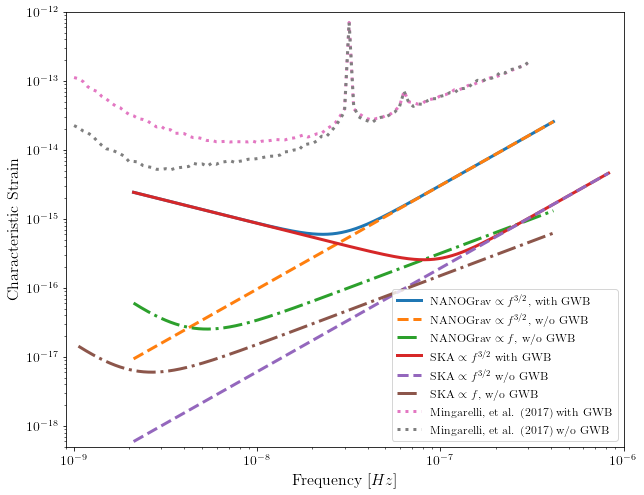

In [44]:
plt.figure(figsize=(10,8))
plt.loglog(NANOGrav_f_1,np.sqrt(NANOGrav_f_1)*NANOGrav_S_n_f_1, linewidth = linesize,\
           label = r'NANOGrav $\propto f^{3/2}$, with GWB')
plt.loglog(NANOGrav_f_3,np.sqrt(NANOGrav_f_3)*NANOGrav_S_n_f_3,linestyle = '--', linewidth = linesize,\
           label = r'NANOGrav $\propto f^{3/2}$, w/o GWB')
plt.loglog(NANOGrav_f_2,NANOGrav_strain,linestyle = '-.', linewidth = linesize,\
           label = r'NANOGrav $\propto f$, w/o GWB')
plt.loglog(SKA_f_3,np.sqrt(SKA_f_3)*SKA_S_n_f_3, linewidth = linesize,\
           label = r'SKA $\propto f^{3/2}$ with GWB')
plt.loglog(SKA_f_4,np.sqrt(SKA_f_4)*SKA_S_n_f_4,linestyle = '--', linewidth = linesize,\
           label = r'SKA $\propto f^{3/2}$ w/o GWB')
plt.loglog(SKA_f_2,SKA_strain,linestyle = '-.', linewidth = linesize,\
           label = r'SKA $\propto f$, w/o GWB')
plt.loglog(NANOGrav_file_f,NANOGrav_file_h_f,linestyle = ':', linewidth = linesize,\
           label = r'Mingarelli, et al. (2017) with GWB')
plt.loglog(NANOGrav_file_f_2,NANOGrav_file_h_f_2,linestyle = ':', linewidth = linesize,\
           label = r'Mingarelli, et al. (2017) w/o GWB')


plt.tick_params(axis = 'both',which = 'major', labelsize = axissize)
plt.ylim([5e-19,1e-12])
plt.xlim([9e-10,1e-6])
#plt.title('NANOGrav (15yr)',fontsize=labelsize)
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend(loc='lower right', fontsize = 12)
plt.show()

####################################################################
# Calculate LISA amplitude spectral densities for various models

### LISA Calculation without pathfinder correction (2016 model)

In [20]:
#LISA Calculation without pathfinder correction (2016 model)
S_sci = 8.9e-12*u.m
S_loc = 1.7e-12*u.m
S_other = 2e-12*u.m

S_acc_low_knee = 30.*u.uHz.to('Hz')*u.Hz
S_acc_high_knee = 0.1*u.mHz.to('Hz')*u.Hz
S_acc_low = 1.8e-14*u.m/u.s/u.s
S_acc_high = 3e-15*u.m/u.s/u.s

#Make a dictionary of dictionaries to put all instrument values, minima, and maxima in a nice, concise form
Martin_LISA_inst_var_dict = {'L':{'val':L},
                 'Tobs':{'val':LISA_T_obs},
                 'S_sci':{'val':S_sci},
                 'S_loc':{'val':S_loc},
                 'S_other':{'val':S_other},
                 'S_acc_low_knee':{'val':S_acc_low_knee},
                 'S_acc_high_knee':{'val':S_acc_high_knee},
                 'S_acc_low':{'val':S_acc_low},
                 'S_acc_high':{'val':S_acc_high}}

k2016_f,k2016_S_n_f_sqrt = SnN.MartinSensitivity(Martin_LISA_inst_var_dict)

### LISA Calculation WITH (Sean's) pathfinder correction

In [21]:
#LISA Calculation WITH (Sean's) pathfinder correction
Ssci = 8.9e-12**2*u.m*u.m
Sloc = 1.7e-12**2*u.m*u.m
Sother = 2e-12**2*u.m*u.m
k2016_P_ims = Ssci+2*Sloc+Sother
pathfinder_S_acc = ((60e-15*u.m/u.s/u.s)**2*(20e-6*u.Hz/fT)**10 + (1.74e-15*u.m/u.s/u.s)**2)/(2*np.pi*fT)**4 #Update Pathfinder Acceleration Noise
pathfinder_S_n_f_sqrt = SnN.Get_ASD_from_PSD_LISA(fT,LISA_Transfer_Function,pathfinder_S_acc,k2016_P_ims,L) #Updated LISA noise curve with Pathfinder Acc noise

### LISA Calculation from https://arxiv.org/pdf/1702.00786.pdf (Amaro-Seaone 2017)

In [22]:
S_acc_low_knee = .4*u.mHz.to('Hz')*u.Hz
S_acc_high_knee = 8.*u.mHz.to('Hz')*u.Hz
S_oms_knee = 2.*u.mHz.to('Hz')*u.Hz
S_acc = 3e-15*u.m/u.s/u.s
S_ims = 10e-12*u.m

#Make a dictionary of dictionaries to put all instrument values, minima, and maxima in a nice, concise form
ESA_LISA_inst_var_dict = {'L':{'val':L},
                 'Tobs':{'val':LISA_T_obs},
                 'S_acc_low_knee':{'val':S_acc_low_knee},
                 'S_acc_high_knee':{'val':S_acc_high_knee},
                 'S_oms_knee':{'val':S_oms_knee},
                 'S_acc':{'val':S_acc},
                 'S_ims':{'val':S_ims}}
ESA_f,ESA_S_n_f_sqrt = SnN.LisaSensitivity(ESA_LISA_inst_var_dict)

### Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf

In [23]:
#Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf
Neil_S_acc = 3e-15*u.m/u.s/u.s #M/sqrt(Hz)
Neil_S_oms = 1.5e-11*u.m
    
#Make a dictionary of dictionaries to put all instrument values, minima, and maxima in a nice, concise form
Neil_LISA_inst_var_dict = {'Tobs':{'val':LISA_T_obs},
                 'L':{'val':L},
                 'S_acc':{'val':Neil_S_acc},
                 'S_oms':{'val':Neil_S_oms}}

Neil_f,Neil_S_n_f_sqrt = SnN.NeilSensitivity(Neil_LISA_inst_var_dict)

#######################################################################
# BBH strain calculation

In [24]:
#Vars = [M,q,chi1,chi2,z]
M = [1e6,65.0,1e10]
q = [1.0,18.0,1.0]
x1 = [0.95,0.0,-0.95]
x2 = [0.95,0.0,-0.95]
z = [3.0,0.093,20.0]

Vars1 = [M[0],q[0],x1[0],x2[0],z[0]]
Vars2 = [M[1],q[1],x1[1],x2[1],z[1]]
Vars3 = [M[2],q[2],x1[2],x2[2],z[2]]

In [25]:
print(Vars1)
print(Vars2)
print(Vars3)

[1000000.0, 1.0, 0.95, 0.95, 3.0]
[65.0, 18.0, 0.0, 0.0, 0.093]
[10000000000.0, 1.0, -0.95, -0.95, 20.0]


In [26]:
#From PhenomD
[phenomD_f_1,phenomD_h_1] = SnN.Get_Waveform(Vars1,f_low=1e-4)
[phenomD_f_2,phenomD_h_2] = SnN.Get_Waveform(Vars2,f_low=1e-4)
[phenomD_f_3,phenomD_h_3] = SnN.Get_Waveform(Vars3)

In [27]:
#Get characteristic strain
[phenomD_f_1,phenomD_h_char_1] = SnN.Get_CharStrain(Vars1,phenomD_f_1,phenomD_h_1)
[phenomD_f_2,phenomD_h_char_2] = SnN.Get_CharStrain(Vars2,phenomD_f_2,phenomD_h_2)
[phenomD_f_3,phenomD_h_char_3] = SnN.Get_CharStrain(Vars3,phenomD_f_3,phenomD_h_3)

In [28]:
#Get monochromatic strain
[mono_idx_1,h_mono_1] = SnN.Get_MonoStrain(Vars1,LISA_T_obs,fT[np.argmin(ESA_S_n_f_sqrt)],fT)
[mono_idx_2,h_mono_2] = SnN.Get_MonoStrain(Vars2,ET_T_obs,ET_f[np.argmin(ET_S_n_f)],ET_f)
[mono_idx_3,h_mono_3] = SnN.Get_MonoStrain(Vars3,T_nano,NANOGrav_f_1[np.argmin(NANOGrav_S_n_f_1)],NANOGrav_f_1)

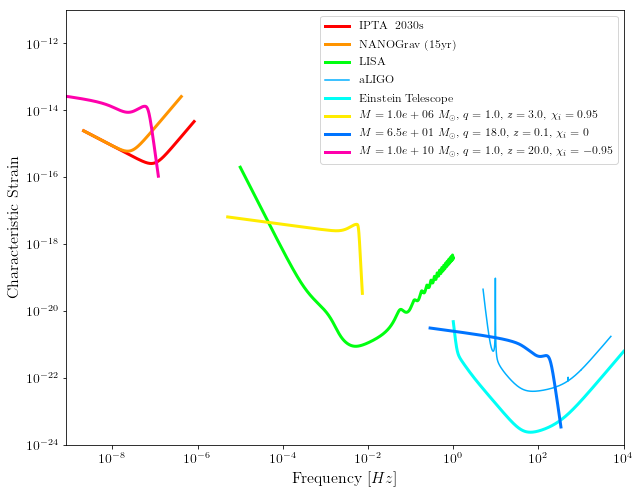

In [45]:
fig,ax = plt.subplots(figsize = figsize)
#plt.loglog(NANOGrav_f,NANOGrav_h_f)
ax.loglog(SKA_f_3,np.sqrt(SKA_f_3)*SKA_S_n_f_3, linewidth = linesize,color = cm.hsv(colornorm(0.0)),label = 'IPTA ~2030s')
ax.loglog(NANOGrav_f_1,np.sqrt(NANOGrav_f_1)*NANOGrav_S_n_f_1, linewidth = linesize,color = cm.hsv(colornorm(0.5)),label = 'NANOGrav (15yr)')
ax.loglog(ESA_f,np.sqrt(ESA_f)*ESA_S_n_f_sqrt, linewidth = linesize,color = cm.hsv(colornorm(1.75)),label = 'LISA')
ax.loglog(aLIGO_f,np.sqrt(aLIGO_f)*aLIGO_S_n_f,color = cm.hsv(colornorm(2.8)),label = 'aLIGO')
ax.loglog(ET_f,np.sqrt(ET_f)*ET_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(2.5)),label = 'Einstein Telescope')
ax.loglog(phenomD_f_1,phenomD_h_char_1, linewidth = linesize,color = cm.hsv(colornorm(0.8)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.2f$' %(M[0],q[0],z[0],x1[0]))
ax.loglog(phenomD_f_2,phenomD_h_char_2, linewidth = linesize,color = cm.hsv(colornorm(3.0)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.0f$' %(M[1],q[1],z[1],x1[1]))
ax.loglog(phenomD_f_3,phenomD_h_char_3, linewidth = linesize,color = cm.hsv(colornorm(4.5)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.2f$' %(M[2],q[2],z[2],x1[2]))
'''ax.scatter(fT[mono_idx_1],h_mono_1)
ax.scatter(ET_f[mono_idx_2],h_mono_2)
ax.scatter(NANOGrav_f[mono_idx_3],h_mono_3)'''


ax.set_xlim([8e-10, 1e4])
ax.set_ylim([1e-24, 1e-11])
ax.tick_params(axis = 'both',which = 'major', labelsize = axissize)

ax.set_xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
ax.set_ylabel('Characteristic Strain',fontsize = labelsize)
ax.legend(loc='upper right', fontsize = legendsize)
plt.show()

In [46]:
#########################
#Save Figure to File
figname = '/Char_Strain_v1.pdf'
figloc = current_path+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')